In [1]:
import os
import time
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
# wrapper so that model predicts using dask
from dask_ml.wrappers import ParallelPostFit  

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

from joblib import dump

import model_prep_and_evals as mpe 

In [2]:
# **************************************************************
# whole_set = True => merge train+test sets and train model with combined dataset
# whole_set = False => train model only with train set

whole_set = False

#root = os.path.join(os.getcwd(), 'processing_results', 'model_3070')
root = os.getcwd()
train_name = 'glcm_spectral_window_model3070_train_2020.csv'
test_name = 'glcm_spectral_window_model3070_test_2020.csv'

first_feature = 'r'
last_feature = 'ndvi_entr5'
label_name = 'iceplant'

# drops this feature
filter_year = True
year = 2020

save_model = False
model_name = 'model3070FP_2020_rfc'

calculate_feature_importance = True

In [3]:
cols = ['r','r_avg', 'r_entr5', 'r_contN',  'r_corrN', #'r_corrN', # spectral
        'g','g_avg', 'g_entr5', #'g_contN',  'g_corrN', #'g_corrN',
        'b','b_avg', 'b_entr5', 'b_contN',  'b_corrN', #'b_corrN',
        'nir', 'nir_avg', 'nir_entr5', 'nir_contN', 'nir_corrN',# 'nir_corrN',
         'year', 'month', 'day_in_year' # date
             ]

In [4]:
# ------------------------------
# IMPORT TRAIN DATA
X_train = pd.read_csv(os.path.join(root, train_name)).loc[:, first_feature:last_feature]
y_train = pd.read_csv(os.path.join(root, train_name)).loc[:,label_name] 

# ------------------------------
# IMPORT TEST DATA
X_test = pd.read_csv(os.path.join(root, test_name)).loc[:, first_feature:last_feature]
y_test = pd.read_csv(os.path.join(root, test_name)).loc[:,label_name] 



X_test = X_test[cols]
X_train = X_train[cols] 


# ------------------------------
if filter_year:
    
    X_train = X_train.loc[X_train.year == year]
    X_train = X_train.drop(['year'], axis =1)
    y_train = y_train.iloc[X_train.index]

    
    X_test = X_test.loc[X_test.year == year]
    X_test = X_test.drop(['year'], axis =1)
    y_test = y_test.iloc[X_test.index]
    
# ------------------------------
if whole_set == True:
    X_train = pd.concat([X_train, X_test], axis = 0)
    y_train = pd.concat([y_train, y_test], axis = 0)


X_test.columns == X_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [5]:
X_train.columns

Index(['r', 'r_avg', 'r_entr5', 'r_contN', 'r_corrN', 'g', 'g_avg', 'g_entr5',
       'b', 'b_avg', 'b_entr5', 'b_contN', 'b_corrN', 'nir', 'nir_avg',
       'nir_entr5', 'nir_contN', 'nir_corrN', 'month', 'day_in_year'],
      dtype='object')

In [6]:
mpe.test_train_proportions(y_train, y_test)

TRAIN SET COUNTS:
no-iceplant:iceplant ratio     2.0 :1
          counts  percentage
iceplant                    
0.0         1077       66.85
1.0          534       33.15

TEST SET COUNTS:
no-iceplant:iceplant ratio     2.0 :1
          counts  percentage
iceplant                    
0.0          463       66.81
1.0          230       33.19



In [7]:
# ------------------------------
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [8]:
t0 = time.time()
rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, 
                                             random_state = 42))
rfc.fit(X_train, y_train)
print(time.time() - t0)

if save_model:
    dump(rfc, model_name +'.joblib')

0.38867712020874023


In [9]:
if whole_set == False:
    preds = rfc.predict(X_test.to_numpy())
    mpe.print_accuracy_info(y_test.to_numpy(), preds)

true negatives: 439     false positives: 24
false negatives: 36     true positives: 194

sensitivity (TP/P): 84.35 %
specificity (TN/N): 94.82 %
G-mean:  0.89

precision (TP/(TP+FP)): 88.99 %

MCC:  0.8028019392815868

F1-measure:  0.86607
F0.5-measure (min false positives):  0.88022
F2-measure (min false negatives)  :  0.85237

accuracy: 91.34 %


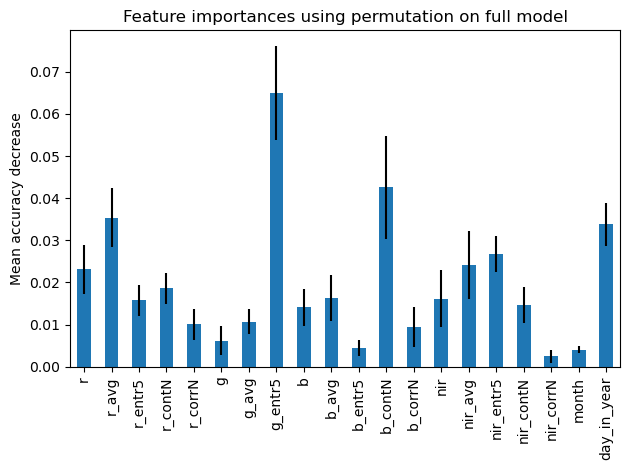

In [10]:
result = permutation_importance(
    rfc, 
    X_test.to_numpy(),
    y_test.to_numpy(),
    n_repeats=10, 
    random_state=42, 
    n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()